In [1]:
# 导入模块
import Solarclip_test
from Solarclip_test import plot_matrix_with_images,calculate_loss,calculate_loss_reconstruction
from Data import Solardataloader_subset
from Model.SolarCLIP import get_model_from_args
from Model.decoder import get_decoder_from_args

import torch
import numpy as np
import matplotlib.pyplot as plt

import os
import torch 
import json
from types import SimpleNamespace

In [2]:
encoder_json_path = './configs/args1.json'
decoder_json_path = './configs/decoder/args1.json'
load_id = 200

with open(encoder_json_path, 'r') as f:
    args_encoder = json.load(f)
    args_encoder = SimpleNamespace(**args_encoder)
for arg in vars(args_encoder):
    print(f"{arg:<30}: {getattr(args_encoder, arg)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open(decoder_json_path, 'r') as f:
    args = json.load(f)
    args = SimpleNamespace(**args)

args.out_dim =1024

encoder_checkpoint_path = args_encoder.checkpoint_path
encoder_checkpoint_path += args_encoder.token_type + '/'
for i in range(len(args_encoder.modal_list)):
    encoder_checkpoint_path += args_encoder.modal_list[i] + '_'
    for j in range(len(args_encoder.enhance_list[i])):
        encoder_checkpoint_path += str(args_encoder.enhance_list[i][j]) + '_'
print(encoder_checkpoint_path)

# if args.load_id is None:    #todo
#     load_id = args_encoder.epochs
#     for i in range(21):
#         _ = f'{encoder_checkpoint_path}/model/epoch_{i}.pt'
#         if os.path.exists(_):
#             load_encoder_dir = _
#     assert load_encoder_dir is not None
# else:
load_encoder_dir = f'{encoder_checkpoint_path}/model/epoch_{args.load_id}.pt'
load_decoder_dir = f'{encoder_checkpoint_path}/decoder/magnet/model/epoch_50.pt'

SolarModel = get_model_from_args(args_encoder)
SolarModel.load_state_dict(torch.load(load_encoder_dir)['model'])
SolarModel = SolarModel.to(device)

Decoder = get_decoder_from_args(args).to(device)  
Decoder.load_state_dict(torch.load(load_decoder_dir)['model'])
Decoder = Decoder.to(device)


config_dir                    : None
batch_size                    : 400
learning_rate                 : 0.1
epochs                        : 100
test_freq                     : 10
save_freq                     : 2
num_workers                   : 16
embed_dim                     : 512
vision_width                  : 768
image_resolution_mag          : 224
vision_layers_mag             : 12
vision_patch_size_mag         : 32
image_resolution_H            : 224
vision_layers_H               : 12
vision_patch_size_H           : 32
token_type                    : all embedding
modal_list                    : ['magnet', '0094']
enhance_list                  : [['None', 1], ['None', 1]]
image_preprocess              : [224, 0.5, 90]
device                        : cuda:0
checkpoint_path               : /mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/
/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/magnet_None_1_0094_None_1_


Text(0.5, 1.0, 'Test MAE\n Last 10% mean: 415.53%')

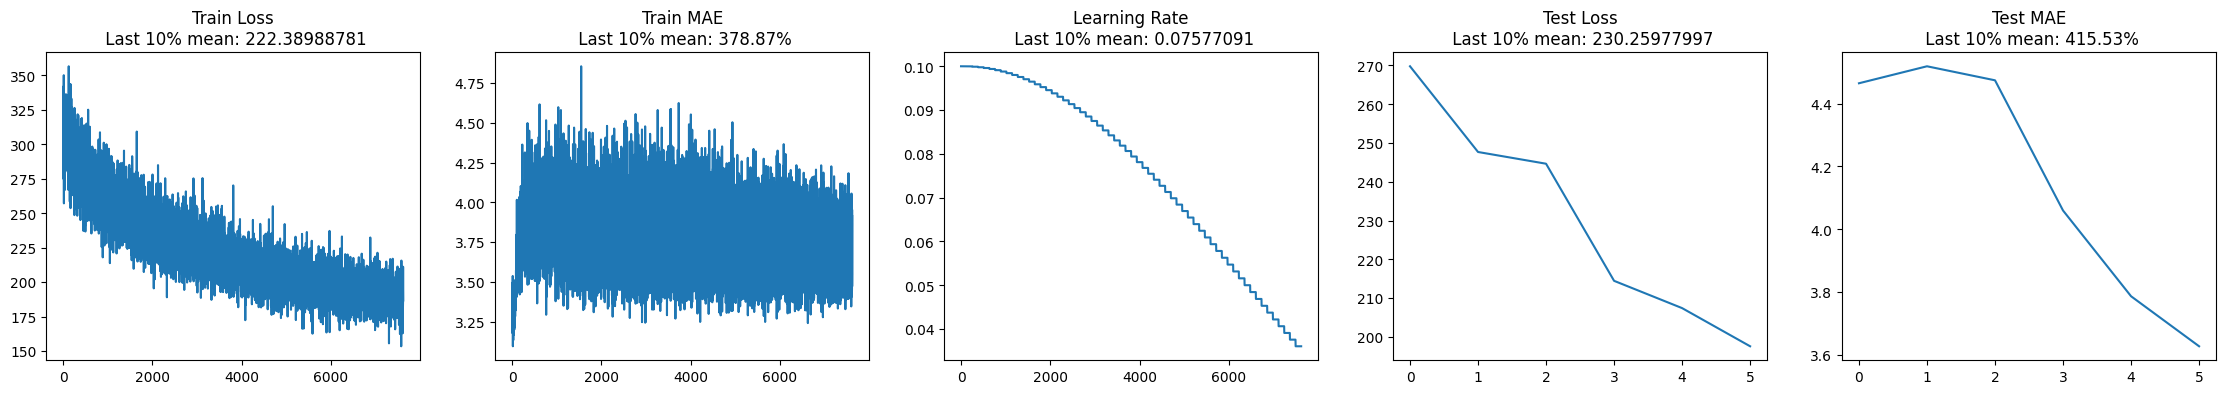

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# log_dir = f'{checkpoint_path}/logger'

log_dir = '/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/magnet_None_1_0094_None_1_/decoder/magnet/logger'
# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_PSNR.pkl', 'rb') as f:
    logger_train_mae = pickle.load(f)
with open(log_dir + '/logger_lr.pkl', 'rb') as f:
    logger_lr = pickle.load(f)
with open(log_dir + '/logger_val_loss.pkl', 'rb') as f:
    logger_val_loss = pickle.load(f)
with open(log_dir + '/logger_val_PSNR.pkl', 'rb') as f:
    logger_val_mae = pickle.load(f)

visualization_num = int(len(logger_val_loss)*0.1)

plt.figure(figsize=(28, 4))

plt.subplot(1,5,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,5,2)
plt.plot(logger_train_mae)
train_mae_last = np.mean(logger_train_mae[-visualization_num:])
plt.title('Train MAE\n Last 10% mean: {:.2%}'.format(train_mae_last))

plt.subplot(1,5,3)
plt.plot(logger_lr)
train_lr = np.mean(logger_lr[-visualization_num:])
plt.title('Learning Rate\n Last 10% mean: {:.8f}'.format(train_lr))

plt.subplot(1,5,4)
plt.plot(logger_val_loss)
test_loss_last = np.mean(logger_val_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,5,5)
plt.plot(logger_val_mae)
test_mae_last = np.mean(logger_val_mae[-visualization_num:])
plt.title('Test MAE\n Last 10% mean: {:.2%}'.format(test_mae_last))


In [37]:
from Data.utils import transfer_date_to_id
from Data.Solardataloader import transfer_log1p

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)


val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 5, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    Decoder = Decoder.eval()
    for i, data in enumerate(val_loader):
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        mag_image = mag_image.to(device)
        h_image = h_image.to(device)
        mag_features = SolarModel.encode_mag(mag_image)   #shape = [batch_size, length,embed_dim]
        H_features = SolarModel.encode_H(h_image)
        mag_features, h_features = mag_features[:,1:,:], H_features[:,1:,:]  ##all embedding
        mag_recon = Decoder(mag_features) #[B,224]
        h_recon = Decoder(h_features)
        
        break

vis_ids = np.arange(5)

mag_image = mag_image[vis_ids].cpu().numpy()
mag_image = transfer_log1p(mag_image)

mag_recon = mag_recon[vis_ids].cpu().numpy()
mag_recon = transfer_log1p(mag_recon)

h_image = h_image[vis_ids].cpu().numpy()
h_image = transfer_log1p(h_image)

h_recon = h_recon[vis_ids].cpu().numpy()
h_recon = transfer_log1p(h_recon)


5346720 7450560
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 71 samples


In [38]:
mag_features = mag_features[vis_ids].cpu().numpy()
mag_features = mag_features[0]
h_features = h_features[vis_ids].cpu().numpy()
h_features = h_features[0]


mag_mean = np.mean(mag_features, axis=1)
mag_var = np.var(mag_features, axis=1)
h_mean = np.mean(h_features, axis=1)
h_var = np.var(h_features, axis=1)

print('mag_mean:',mag_mean)
print('0094_mean:',h_mean)
print('mag_var:',mag_var)
print('0094_var:',h_var)

mag_mean: [ 0.01874182  0.15268144  0.14896478  0.12565258  0.13948196  0.05226484
  0.02436135  0.11973095  0.11083181  0.10004646  0.14142483  0.1197606
  0.08641937  0.11786643 -0.01819225  0.07461715 -0.03093179 -0.025926
 -0.01867166 -0.00862945  0.15703923 -0.10357764  0.18186039  0.06678012
  0.13591217 -0.00678135  0.08686411  0.02272064  0.00953538  0.01013044
  0.04703851  0.03718533  0.07225104  0.08687137  0.04113886 -0.03099544
  0.04382422  0.01013984  0.06286292  0.06466858 -0.0172907  -0.0357335
  0.00276984 -0.07509688 -0.13051252  0.03899401 -0.04417505  0.07530527
  0.01010006]
0094_mean: [ 0.11794932  0.13726926  0.14151865  0.15302327  0.15690792  0.16933334
  0.08736949  0.13569272  0.14178395  0.06875978  0.09014038 -0.0202775
  0.17762537  0.14126527  0.04740993  0.03203839  0.04237996 -0.07575948
 -0.09883288 -0.02387994  0.05296062  0.00596025  0.15094915  0.03554938
  0.07322825  0.08246038  0.05358706 -0.05274262 -0.02874419  0.09457
 -0.01383559 -0.08785692

In [39]:
from Data.utils import transfer_date_to_id
from Data.Solardataloader import transfer_log1p

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)


val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 5, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    Decoder = Decoder.eval()
    for i, data in enumerate(val_loader):
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        mag_image = mag_image.to(device)
        h_image = h_image.to(device)
        mag_features = SolarModel.encode_mag(mag_image)   #shape = [batch_size, length,embed_dim]
        H_features = SolarModel.encode_H(h_image)
        mag_features, h_features = mag_features[:,1:,:], H_features[:,1:,:]  ##all embedding
        mag_recon = Decoder(mag_features) #[B,224]
        h_recon = Decoder(h_features)
        
        break

vis_ids = np.arange(5)

mag_image = mag_image[vis_ids].cpu().numpy()



mag_var: [3.641007  4.062784  3.5533757 3.1345484 3.1647859 3.1779687 3.235601
 4.1941433 3.6166325 3.687154  3.5507045 3.1563256 2.9430187 3.5085855
 3.83365   2.971494  3.3353837 2.690961  3.142415  3.1124272 3.355255
 3.7656975 3.1635728 3.4729927 3.9057727 2.4062958 2.9342947 3.3254802
 2.8449488 3.578641  3.6260831 1.9565821 3.4665399 2.714598  2.5238023
 3.895411  2.9832373 2.9337764 3.3012714 3.4232712 2.87596   2.4638739
 3.354213  3.932498  3.5084612 3.4028199 2.4302669 3.2810044 3.186338 ]
0094_var: [3.4166338 3.8338652 3.9760008 4.3285975 4.6281185 4.867924  5.3140326
 3.753595  3.9916131 3.0772462 3.64995   2.7932804 5.2352004 5.004303
 3.048844  4.3089886 3.0838413 2.9012804 2.8315792 2.8009384 4.38746
 3.0541196 4.1718483 2.8836257 3.29834   3.4557304 3.1022685 3.5899098
 2.956911  3.8400834 2.6727238 3.0581317 2.2746415 3.3815444 3.5498633
 2.6659987 2.6034029 3.3899548 2.833635  3.0400686 4.730323  4.739638
 2.92944   2.3970919 2.5210247 3.3666697 3.4347312 3.3289988 4.

In [37]:
from Data.utils import transfer_date_to_id
from Data.Solardataloader import transfer_log1p
from einops import rearrange
from Solarclip_test import calculate_loss

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)
print(start_date,end_date)


val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=12*24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 5, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    Decoder = Decoder.eval()
    for i, data in enumerate(val_loader):
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        mag_image = mag_image.to(device)
        h_image = h_image.to(device)
        mag_features = SolarModel.encode_mag(mag_image)   #shape = [batch_size, length,embed_dim]
        H_features = SolarModel.encode_H(h_image)
        mag_features, h_features = mag_features[:,1:,:], H_features[:,1:,:]  ##all embedding
        mag_recon = Decoder(mag_features) #[B,224,224]
        h_recon = Decoder(h_features)
        data = data.to(device)
        loss, loss_inner, acc, logits_per_mag, inner_cor_matrix = calculate_loss(SolarModel,data,inner_loss_rate=0)
        logits_per_mag = logits_per_mag/SolarModel.logit_scale.exp()
        logits_per_mag = logits_per_mag.cpu().numpy()

        break



5346720 7450560
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 71 samples


[[0.3835038  0.3201426  0.35045627 0.3552     0.34331313]
 [0.32008064 0.3460184  0.29337034 0.3228328  0.3050401 ]
 [0.33959544 0.3398528  0.35919836 0.34694216 0.35318092]
 [0.35047987 0.34007248 0.3297489  0.3692014  0.3279938 ]
 [0.31143263 0.34530097 0.31026572 0.33750197 0.32184458]]


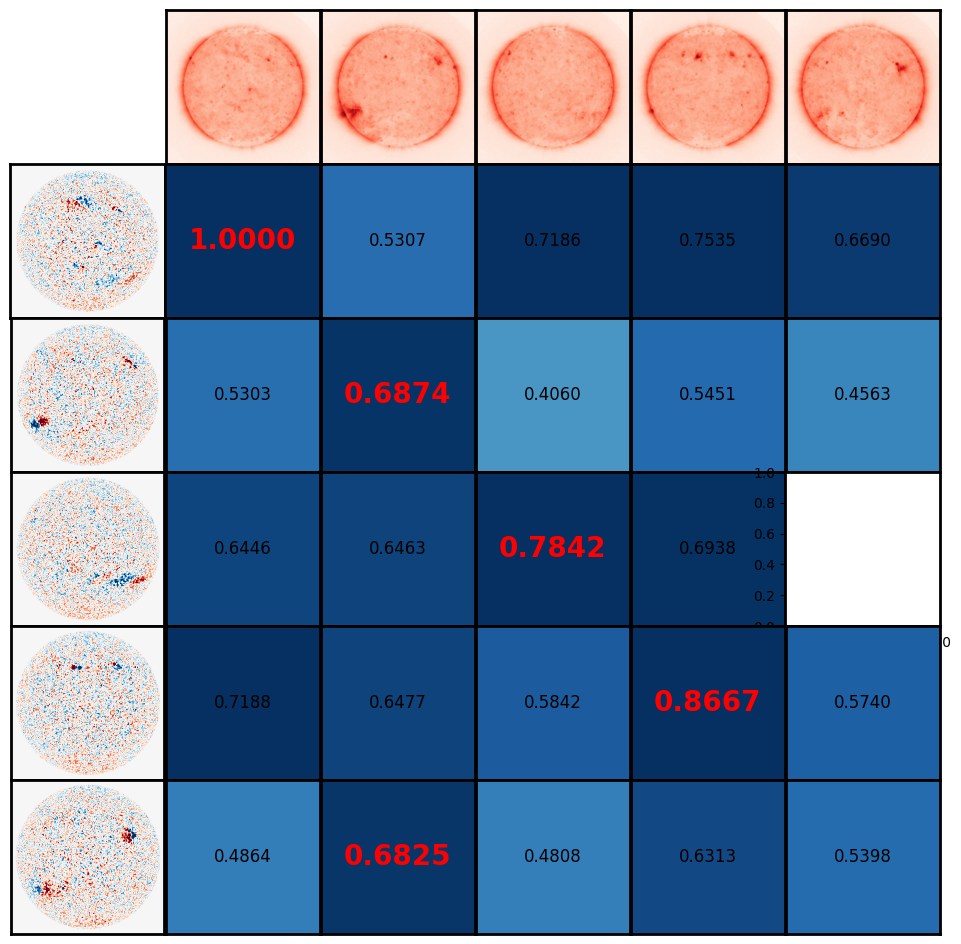

In [38]:
vis_ids = np.arange(5)

mag_image = mag_image[vis_ids].cpu().numpy()
mag_image = transfer_log1p(mag_image)

mag_recon = mag_recon[vis_ids].cpu()
mag_recon = transfer_log1p(mag_recon)

h_image = h_image[vis_ids].cpu().numpy()
h_image = transfer_log1p(h_image)

logits_per_mag = logits_per_mag[vis_ids,:][:,vis_ids]
print(logits_per_mag)


plot_matrix_with_images(logits_per_mag,inner_cor_matrix,mag_image,h_image)




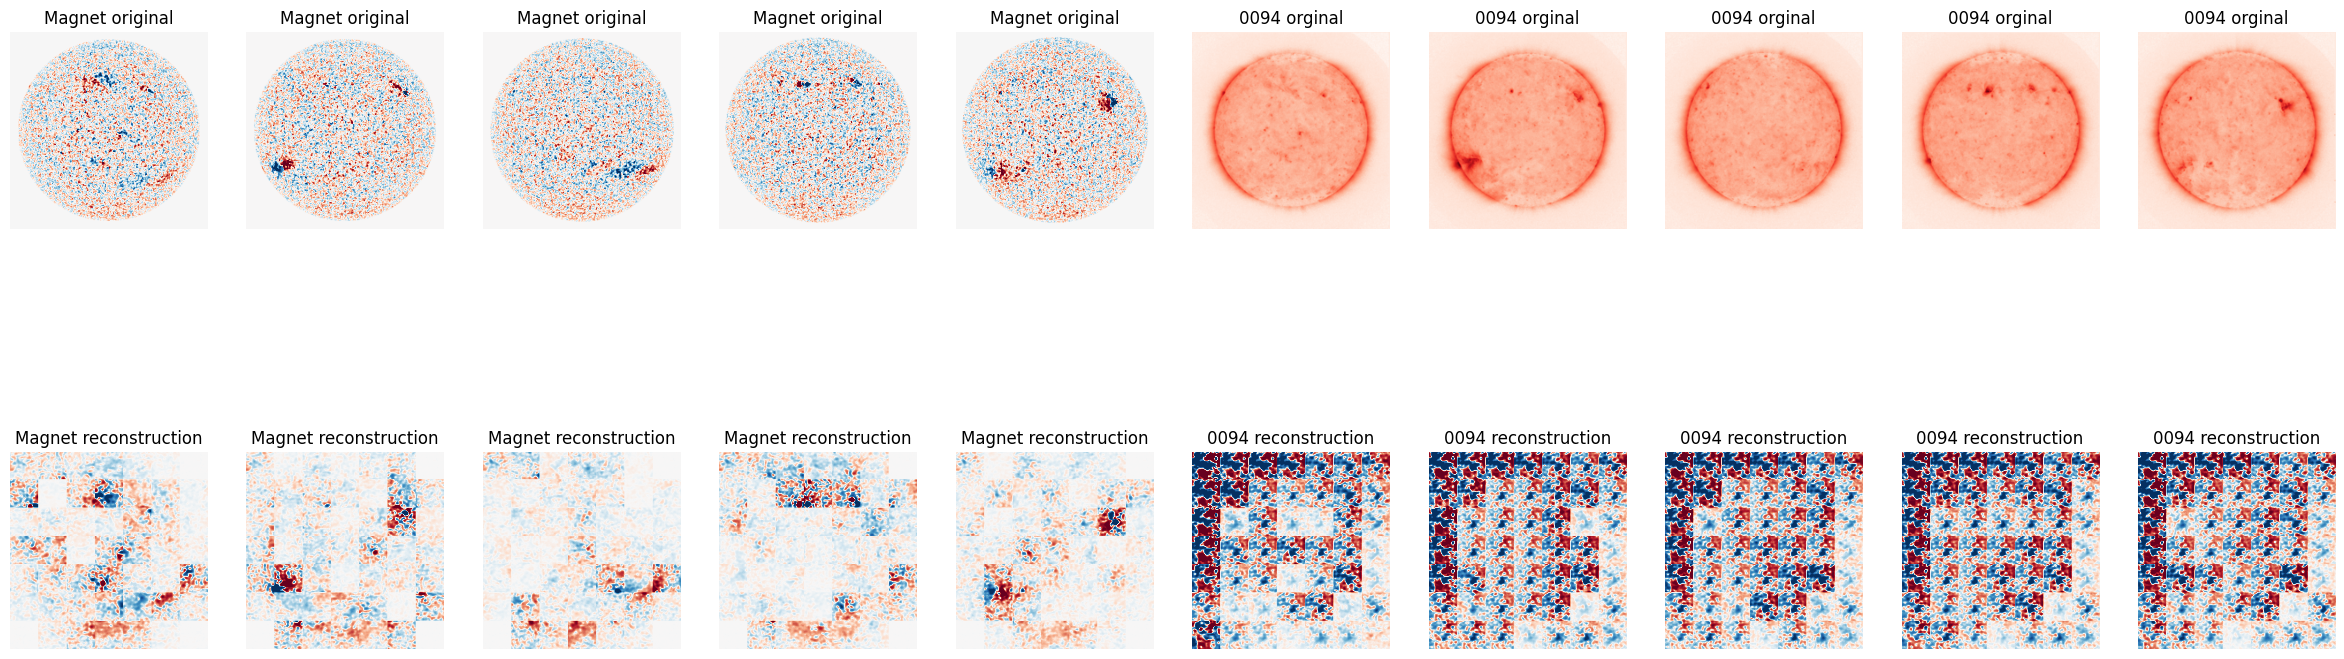

In [29]:
import matplotlib.pyplot as plt

vis_ids = np.arange(5)

vmin_magnet = np.min(mag_image)
vmax_magnet = np.max(mag_image)
vmax_magnet = np.max([np.abs(vmin_magnet), np.abs(vmax_magnet)])/2
vmin_magnet = -vmax_magnet

vmin_0094 = np.min(h_image)
vmax_0094 = np.max(h_image)


plt.figure(figsize=(30, 10))
for i in range(5):
    plt.subplot(2, 10, i+1)
    plt.imshow(mag_image[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet original')
    plt.subplot(2, 10, i+6)
    plt.imshow(h_image[i,0,:,:], cmap='Reds',vmin=vmin_0094, vmax=vmax_0094)
    plt.axis('off')
    plt.title('0094 orginal')
    plt.subplot(2, 10, i+11)
    plt.imshow(mag_recon[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('Magnet reconstruction')
    plt.subplot(2, 10, i+16)
    plt.imshow(h_recon[i,0,:,:], cmap='RdBu_r',vmin=vmin_magnet, vmax=vmax_magnet)
    plt.axis('off')
    plt.title('0094 reconstruction')


images of different modals

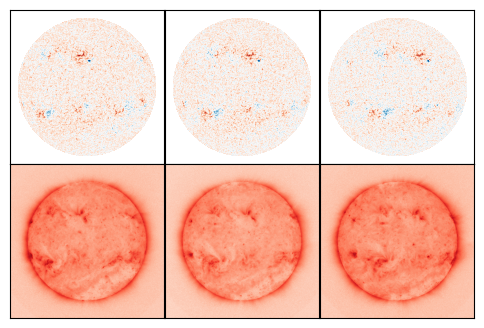

In [20]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from Data.Solardataloader import transfer_log1p

fig,ax = plt.subplots(2,3,figsize=(6,4))

for i in range(2,5):
    vmin = 0
    vmax = 10
    # path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2013040{i}_0000_0335.fits'
    path = f'/mnt/nas/home/huxing/202407/nas/data/hmi/fits/hmi.M_720s.2010070{i}_150000_TAI.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[0,i-2].imshow(img,cmap='RdBu_r')
    ax[0, i-2].set_xticks([])
    ax[0, i-2].set_yticks([])
    path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2010070{i}_1000_0094.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[1,i-2].imshow(img,cmap='Reds')
    ax[1, i-2].set_xticks([])
    ax[1, i-2].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)


plt.show()
